<a href="https://colab.research.google.com/github/LukeWeidenwalker/fastai-notebooks/blob/master/08_movielens_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastai

     |████████████████████████████████| 204kB 8.4MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 


In [2]:
from fastai.collab import *
from fastai.tabular.all import *
import pandas as pd

In [3]:
path = untar_data(URLs.ML_100k)

In [4]:
raw_df = pd.read_csv(path/"u.data", delimiter="\t", names=["user_id", "item_id", "rating", "timestamp"])
raw_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movie_df = pd.read_csv(path/"u.item", delimiter="|", encoding="latin-1", usecols=(0,1), names=('movie','title'), header=None)
movie_df.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
ratings = raw_df.merge(movie_df, left_on="item_id", right_on="movie")
ratings.drop(["movie"], axis=1, inplace=True)
ratings.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [8]:
dls = CollabDataLoaders.from_df(ratings, item_name="title", rating_name="rating", bs=64)

In [9]:
print(f"Number of Users: {len(dls.classes['user_id'])}")
print(f"Number of Movies: {len(dls.classes['title'])}")

Number of Users: 944
Number of Movies: 1665


In [ ]:
# (tensor(user_ids, movie_ids), tensor(ratings))
# shape=(64, 2)                 shape=(64, 1) 
dls.one_batch()[0].shape

torch.Size([64, 2])

In [41]:
batch = dls.one_batch()
print(batch[0][:, 0])
hot = one_hot(batch[0][:, 0], len(dls.classes['user_id'])).float()

tensor([405, 208, 417, 474, 311, 180, 943, 907, 764, 671,  23, 642, 561,  95,
        109,  90, 293, 301, 160, 194, 239, 929, 780, 142, 838, 601,   6, 798,
        618, 775,  60, 900, 403, 128, 347, 516, 354,  95, 299, 268, 585, 416,
        207, 181, 561, 450, 892, 885, 537, 433, 405, 569, 215, 793, 417, 727,
        252, 524, 752, 693, 829, 506, 454, 891])


In [23]:
user_factors = torch.randn(len(dls.classes['user_id']), 50)

In [29]:
user_factors.shape, user_factors.t().shape, hot.shape

(torch.Size([944, 50]), torch.Size([50, 944]), torch.Size([944]))

In [58]:
emb = Embedding(5, 4)

In [59]:
for p in emb.parameters():
  print(p)

Parameter containing:
tensor([[ 2.1307e-03,  2.1051e-03,  9.9638e-04,  9.9662e-03],
        [-1.0222e-02,  3.7448e-03, -3.4844e-03,  1.5378e-03],
        [-4.0412e-03, -1.3447e-03, -6.7373e-03,  5.2135e-03],
        [ 4.8824e-04,  6.4750e-03, -2.1057e-03, -2.7050e-03],
        [ 1.8325e-02, -1.9606e-02,  2.4984e-03,  4.2124e-05]],
       requires_grad=True)


In [60]:
emb(tensor([3,4]))

tensor([[ 4.8824e-04,  6.4750e-03, -2.1057e-03, -2.7050e-03],
        [ 1.8325e-02, -1.9606e-02,  2.4984e-03,  4.2124e-05]],
       grad_fn=<EmbeddingBackward>)

In [130]:
class PMFModel(Module):
  def __init__(self, n_users, n_movies, n_user_factors, n_movie_factors):
    self.user_factors = Embedding(n_users, n_user_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_movie_factors)
    self.movie_bias = Embedding(n_movies, 1)
  
  def forward(self, x):
    # x -> [[(user_id, movie_id), rating], ... ]
    res = (self.user_factors(x[:, 0]) * self.movie_factors(x[:, 1])).sum(dim=1, keepdims=True)
    res += self.user_bias(x[:, 0]) + self.movie_bias(x[:, 1])
    return res

In [131]:
n_users = len(dls.classes['user_id'])
n_movies = len(dls.classes['title'])
n_user_factors = 50
n_movie_factors = 50

model = PMFModel(n_users, n_movies, n_user_factors, n_movie_factors)

In [132]:
learn = Learner(dls, model, loss_func=MSELossFlat())

In [134]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.049654,1.110791,00:07
1,1.022256,1.038660,00:07
2,0.891747,0.947849,00:07
3,0.777282,0.869711,00:07
4,0.713082,0.855310,00:07


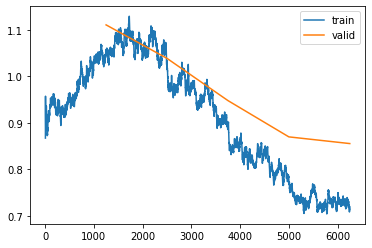

In [135]:
learn.recorder.plot_loss()